In [1]:
target = 'time'
training_mode = 'test'

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
from math import exp
from evaluation import print_feature_importances
from evaluation import plot_cm
from evaluation import print_cr
from evaluation import auc
#import tensorflow as tf
from persistence import model_saver
from preprocessing import scale
from itertools import product

In [3]:
mem_bin_cutoffs = [50, 100, 200, 500, 1000, 2000, 10000, 20000, 50000, 100000]
mem_categories = {i:mem_bin_cutoffs[i] for i in range(len(mem_bin_cutoffs))}

In [4]:
print(mem_categories)

{0: 50, 1: 100, 2: 200, 3: 500, 4: 1000, 5: 2000, 6: 10000, 7: 20000, 8: 50000, 9: 100000}


In [5]:
time_bin_cutoffs = [60, 120, 300, 600, 1800, 3600, 14400, 43200]
time_categories = {i:time_bin_cutoffs[i] for i in range(len(time_bin_cutoffs))}

In [6]:
print(time_categories)

{0: 60, 1: 120, 2: 300, 3: 600, 4: 1800, 5: 3600, 6: 14400, 7: 43200}


# Loading model and associated data

In [7]:
save_path = '/glade/work/jdubeau/model-saves/time_regr_log_gboost_final2021-07-14-15:34/'

In [8]:
ms = model_saver()
ms.load(save_path)

In [9]:
notes, \
    model, model_df, \
    categories_dict, \
    X_features, X_train, \
    y_train_full, X_val, \
    y_val_full, X_test, \
    y_test_full = ms.get_all()

In [10]:
print(notes)

Gradient Boosting Regressor. Trained on training, validation, and test data. Grid search performed. y values transformed with log. X values NOT scaled.


In [11]:
model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 11,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_iter_no_change': None,
 'random_state': 3,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [12]:
model.feature_importances_

array([0.03380903, 0.01980353, 0.01649631, 0.28602903, 0.17979196,
       0.02885392, 0.15602883, 0.02753009, 0.05111863, 0.01661654,
       0.11051785, 0.00445344, 0.04401883, 0.02493201])

In [13]:
X_train_norm, X_val_norm, X_test_norm = scale(X_train, X_val, X_test)

In [21]:
if target == 'mem':
    y_train = np.ravel(y_train_full['mem_category'])
    y_val = np.ravel(y_val_full['mem_category'])
    y_test = np.ravel(y_test_full['mem_category'])
else:
    y_train = np.ravel(y_train_full['time_category'])
    y_val = np.ravel(y_val_full['time_category'])
    y_test = np.ravel(y_test_full['time_category'])

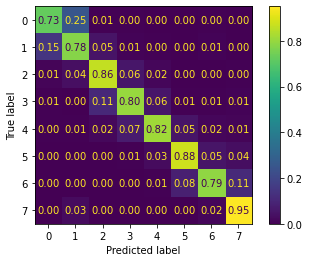

In [22]:
if training_mode == 'test':
    plot_cm(X_test_norm, y_test, model, save=False, path='class-forest-balanced.png')
else:
    plot_cm(X_val_norm, y_val, model)

In [14]:
if training_mode == 'test':
    print_cr(X_test_norm, y_test, model)
else:
    print_cr(X_val_norm, y_val, model)

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1813
           1       0.79      0.78      0.78      2681
           2       0.83      0.86      0.85      1947
           3       0.79      0.80      0.79      1401
           4       0.91      0.82      0.86      1983
           5       0.79      0.88      0.83       995
           6       0.89      0.79      0.84      1392
           7       0.56      0.95      0.71       342

    accuracy                           0.81     12554
   macro avg       0.79      0.83      0.80     12554
weighted avg       0.81      0.81      0.81     12554



In [15]:
if training_mode == 'test':
    auc(X_test_norm, y_test, model)
else:
    auc(X_val_norm, y_val, model)

0.9783540624378664


In [16]:
print_feature_importances(X_features, model)

('PP', 1.961)
('SP', 1.171)
('BR', 0.928)
('rqst_timespan', 35.894)
('rqst_area_rect', 20.6)
('converted', 3.931)
('params_num', 16.379)
('grid_def_num', 2.064)
('level_num', 8.133)
('ds084.1', 2.465)
('ds631.1', 2.679)
('ds083.3', 1.427)
('ds094.0', 0.945)
('ds083.2', 1.424)


In [23]:
def custom_predict(X, model):
    probas = model.predict_proba(X)
    preds = []
    for entry in probas:
        first_guess = np.argmax(entry)
        first_proba = np.amax(entry)
        
        entry[first_guess] = 0
        second_guess = np.argmax(entry)
        second_proba = np.amax(entry)
        
        entry[second_guess] = 0
        third_guess = np.argmax(entry)
        third_proba = np.amax(entry)
        
        if first_proba > 0.7:
            preds.append(first_guess)
        else:
            preds.append(max([first_guess, second_guess, third_guess]))
    return np.array(preds)

In [24]:
dat = X_train_norm[:5]
pred = model.predict(dat)
prob = model.predict_proba(dat)
cpred = custom_predict(dat, model)

for i in range(5):
    print("Probas:")
    print([round(100*val, 1) for val in prob[i]])
    print("Normal prediction:")
    print(pred[i])
    print("Custom prediction:")
    print(cpred[i])
    print('-------')

Probas:
[0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Normal prediction:
1
Custom prediction:
1
-------
Probas:
[0.0, 1.9, 98.0, 0.1, 0.0, 0.0, 0.0, 0.0]
Normal prediction:
2
Custom prediction:
2
-------
Probas:
[0.0, 0.0, 1.4, 3.1, 94.9, 0.1, 0.5, 0.0]
Normal prediction:
4
Custom prediction:
4
-------
Probas:
[5.4, 12.7, 71.5, 6.8, 2.9, 0.0, 0.4, 0.4]
Normal prediction:
2
Custom prediction:
2
-------
Probas:
[46.7, 10.4, 28.4, 7.1, 3.6, 1.5, 2.1, 0.3]
Normal prediction:
0
Custom prediction:
2
-------


In [25]:
def scale_predictions(preds, init_val=2.31, ten_pct_pt=1000):
    '''Scales predictions.
    
       First interprets the predicted category as a memory
       value.
       
       Then multiplies by a scaling value which begins
       at the init_val and decays for higher memory values,
       reaching a value of 1.1 (thus scaling by 10%) at the 
       given value called ten_pct_pt. 
       '''
    
    a = init_val - 1
    b = (1/ten_pct_pt)*math.log(0.1/a)
    
    sc_predictions = []
    for cat in preds:
        if target == 'mem':
            val = mem_categories[cat]
        else:
            val = time_categories[cat]
        val *= 1 + a*exp(b*val)
        val = round(val)
        sc_predictions.append(val)
    return sc_predictions

In [26]:
def evaluation_df(X, y_full, model, init_val=2.31, ten_pct_pt=1000):
    df = y_full.copy()
    if target == 'mem':
        df['mem_delta'] = df.apply(lambda row: 
                               row['req_mem'] - row['used_mem'],
                               axis=1)
        df['pred_cat'] = custom_predict(X, model)
        df['pred_mem'] = scale_predictions(df['pred_cat'],
                                           init_val=init_val,
                                           ten_pct_pt=ten_pct_pt)
        df['pred_delta'] = df.apply(lambda row: row['pred_mem'] - row['used_mem'],
                                    axis=1)
    else:
        df['time_delta'] = df.apply(lambda row: 
                               43200 - row['wall_time'],
                               axis=1)
        df['pred_cat'] = custom_predict(X, model)
        df['pred_time'] = np.array([min(43200, x) 
                                    for  x in
                                    scale_predictions(df['pred_cat'],
                                           init_val=init_val,
                                           ten_pct_pt=ten_pct_pt)])
        df['pred_delta'] = df.apply(lambda row: row['pred_time'] - row['wall_time'],
                                    axis=1)
    return df

In [30]:
init_val = 6.0
ten_pct_pt = 30000

if training_mode == 'test':
    df = evaluation_df(X_test_norm, y_test_full, model, init_val=init_val, ten_pct_pt=ten_pct_pt)
else:
    df = evaluation_df(X_val_norm, y_val_full, model, init_val=init_val, ten_pct_pt=ten_pct_pt)
    
df.sample(10)

,wall_time,time_category,time_delta,pred_cat,pred_time,pred_delta
6377015,238.0,2,42962.0,2,1742,1504.0
6554027,16845.0,7,26355.0,7,43200,26355.0
6142260,359.0,3,42841.0,3,3374,3015.0
6183078,259.0,2,42941.0,2,1742,1483.0
6516911,51.0,0,43149.0,0,358,307.0
6220527,93.0,1,43107.0,1,711,618.0
6491624,692.0,4,42508.0,4,8917,8225.0
6532789,4896.0,6,38304.0,7,43200,38304.0
6420698,53.0,0,43147.0,7,43200,43147.0
6323556,99.0,1,43101.0,2,1742,1643.0


In [47]:
model_df.sample(5)[['rinfo', 'PP', 'SP', 'BR', 'used_mem']].values

array([['&dates=1999-09-30 1999-12-31&lats=46.0 S 45.0 S&lons=68.0 W 67.0 W&rectypes=ADPSFC&allbasic=y&parms=PRES PMSL TMDB ALSE TMDP REHU WDIR WSPD TP03 TP24 HOVI&compr=gz',
        True, False, False, 31.2734375],
       ['gui=yes;dsnum=094.1;startdate=2011-01-01 00:00;enddate=2021-01-01 00:00;parameters=3!7-0.2-1:0.2.2,3!7-0.2-1:0.2.3;product=486;grid_definition=57;level=223;ofmt=netCDF;nlat=2;slat=-1;wlon=117;elon=120',
        False, False, True, 125.99609375],
       ['gui=yes;dsnum=083.3;startdate=2016-01-01 00:00;enddate=2017-01-01 00:00;parameters=3!7-0.2-1:0.3.193,3!7-0.2-1:0.2.10,3!7-0.2-1:0.19.1,3!7-0.2-1:0.0.21,3!7-0.2-1:0.7.193,3!7-0.2-1:0.1.193,3!7-0.2-1:0.1.194,3!7-0.2-1:0.1.192,3!7-0.2-1:0.1.195,3!7-0.2-1:0.6.6,3!7-0.2-1:0.1.22,3!7-0.2-1:0.6.193,3!7-0.2-1:0.7.6,3!7-0.2-1:0.7.7,3!7-0.2-1:0.1.10,3!7-0.2-1:0.1.196,3!7-0.2-1:0.0.6,3!7-0.2-1:0.5.192,3!7-0.2-1:0.4.192,3!7-0.2-1:2.3.203,3!7-0.2-1:0.3.5,3!7-0.2-1:2.0.193,3!7-0.2-1:2.4.2,3!7-0.2-1:0.3.3,3!7-0.2-1:10.2.0,3!7-0.2

In [46]:
def total_loss_info():
    print(f"Number of entries predicted: {df.shape[0]}")
    print("--------")
    print("Number of jobs using more mem/time than predicted: "
          + f"{df[(df.wall_time < 43200) & (df.pred_delta < 0)].shape[0]}")
    print("Average delta for jobs using more than predicted: "
          + f"{round(df[df.pred_delta<0]['pred_delta'].mean(), 2)}")
    print("Sample of jobs using more mem/time than predicted: ")
    if target == 'mem':
        print(df[df.pred_delta < 0][['used_mem', 'mem_category',
                                    'pred_cat', 'pred_mem',
                                    'pred_delta']].sample(5))
        print("--------")
        print("Total unused memory in GB (original): "
              + f"{round(df['mem_delta'].sum()/1024)}")
        print("Total unused memory in GB (predicted): "
              + f"{round(df[df.pred_delta >= 0]['pred_delta'].sum()/1024)}")
    else:
        print(df[(df.wall_time < 43200) & (df.pred_delta < 0)][['wall_time', 'time_category',
                                    'pred_cat', 'pred_time',
                                    'pred_delta']].sample(5))
        print("--------")
        print("Total unused time in years (original): "
              + f"{round(df['time_delta'].sum()/31536000, 4)}")
        print("Total unused time in years (predicted): "
              + f"{round(df[df.pred_delta >= 0]['pred_delta'].sum()/31536000, 4)}")

In [29]:
total_loss_info()

Number of entries predicted: 12554
--------
Number of jobs using more mem/time than predicted: 1
Average delta for jobs using more than predicted: -23929.6
Sample of jobs using more mem/time than predicted: 


ValueError: Cannot take a larger sample than population when 'replace=False'

In [107]:
df[(df.wall_time < 43200) & (df.pred_delta < 0)].index

Int64Index([6547146, 6177199, 6380417, 6380426, 6484998, 6380915, 6485011,
            6245147, 6380414, 6484409, 6485010],
           dtype='int64')

In [108]:
model_df[model_df.index.isin([6547146, 6177199, 6380417, 6380426, 6484998, 6380915, 6485011,
            6245147, 6380414, 6484409, 6485010])]

,request_type,job_start_at,job_end_at,req_mem,used_mem,dsnum,rqst_start_at,rqst_end_at,dates_init,slat,...,PP,SP,BR,converted,ds084.1,ds631.1,ds083.3,ds094.0,ds083.2,time_category
6177199,SP,2020-11-10 06:27:07,2020-11-10 07:44:05,1024.0,330.847656,633.0,2020-06-30 00:00:00+00:00,2020-07-02 23:00:00+00:00,False,-57.0,...,False,True,False,False,False,False,False,False,False,6
6245147,SP,2020-12-02 22:54:13,2020-12-02 23:53:16,30720.0,1030.875000,628.0,2019-01-01 00:00:00+00:00,2019-12-31 18:00:00+00:00,False,NaN,...,False,True,False,True,False,False,False,False,False,5
6380414,PP,2021-01-13 01:07:07,2021-01-13 05:33:33,1024.0,104.445312,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,...,True,False,False,False,False,True,False,False,False,7
6380417,PP,2021-01-13 01:07:07,2021-01-13 05:47:39,1024.0,104.093750,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,...,True,False,False,False,False,True,False,False,False,7
6380426,PP,2021-01-13 01:09:12,2021-01-13 06:12:26,1024.0,104.273438,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,...,True,False,False,False,False,True,False,False,False,7
6380915,PP,2021-01-13 07:13:22,2021-01-13 07:41:19,1024.0,99.503906,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,...,True,False,False,False,False,True,False,False,False,4
6484409,PP,2021-02-06 20:17:09,2021-02-07 00:15:01,1024.0,101.183594,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,...,True,False,False,False,False,True,False,False,False,6
6484998,PP,2021-02-07 06:12:56,2021-02-07 07:52:58,1024.0,36.042969,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,...,True,False,False,False,False,True,False,False,False,6
6485010,PP,2021-02-07 06:15:10,2021-02-07 08:18:23,1024.0,35.976562,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,...,True,False,False,False,False,True,False,False,False,6
6485011,PP,2021-02-07 06:15:10,2021-02-07 08:32:05,1024.0,35.933594,631.1,2000-01-01 00:00:00+00:00,2016-12-31 21:00:00+00:00,False,NaN,...,True,False,False,False,False,True,False,False,False,6


In [20]:
df.sort_values(by='pred_delta').head()

,req_mem,used_mem,mem_category,mem_delta,pred_cat,pred_mem,pred_delta
6500395,51200.0,22910.214844,8,28289.785156,6,11000,-11910.214844
6378404,30720.0,13302.382812,7,17417.617188,6,11000,-2302.382812
6653947,1024.0,939.359375,4,84.640625,0,197,-742.359375
6600160,1024.0,919.480469,4,104.519531,0,197,-722.480469
6145098,1024.0,888.980469,4,135.019531,0,197,-691.980469


In [55]:
used_mems = np.ravel(y_test_full['used_mem'])

def total_loss(X, y_full, init_val, ten_pct_pt):
    preds = scale_predictions(custom_predict(X, model), init_val, ten_pct_pt)
    loss = 0.0
    count = 0
    for i in range(len(preds)):
        pred_delta = preds[i] - used_mems[i]
        if pred_delta >= 0:
            loss += pred_delta
        else:
            # Every improperly classified point is worth 100GB?
            loss += 102400
    return loss/1024

#total_loss(X_test_norm, y_test_full, 1.2, 10000)    


In [59]:
param_grid = {'X':[X_test_norm],
              'y_full':[y_test_full],
              'init_val':[x/100 for x in range(111, 500, 10)],
              'ten_pct_pt':range(500, 20000, 500)}

all_combos = (dict(zip(param_grid.keys(), values)) for values in product(*param_grid.values()))

smallest_loss = 50000
best_combo = None
counter = 0
for combo in all_combos:
    if counter % 50 == 0:
        print(counter)
    current_loss = total_loss(**combo)
    if current_loss < smallest_loss:
        smallest_loss = current_loss
        best_combo = combo
    counter += 1
        
print(smallest_loss)
print(best_combo)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
8729.46491241455
{'X': array([[-2.19726977, -0.25862096,  2.86063769, ..., -0.25500837,
        -0.25358807, -0.25571628],
       [ 0.45511025, -0.25862096, -0.34957241, ..., -0.25500837,
         3.94340316, -0.25571628],
       [ 0.45511025, -0.25862096, -0.34957241, ..., -0.25500837,
        -0.25358807, -0.25571628],
       ...,
       [-2.19726977, -0.25862096,  2.86063769, ..., -0.25500837,
        -0.25358807, -0.25571628],
       [ 0.45511025, -0.25862096, -0.34957241, ..., -0.25500837,
        -0.25358807, -0.25571628],
       [ 0.45511025, -0.25862096, -0.34957241, ..., -0.25500837,
        -0.25358807, -0.25571628]]), 'y_full':          req_mem    used_mem  mem_category
6569024   1024.0  278.906250             3
6222669   1024.0   31.074219             0
6761656   8192.0   31.722656             0
6486486   1024.0   36.328125             0
622095